# Power Consumption Forcasting For Welllington, New Zealand

## Objective:
Predict Zone 1 power consumption using meteorological and environmental features

## Business Understanding

The goal is to predict the **Zone 1 Power Consumption (in KWR)** in Wellington, NZ, using factors like temperature, humidity, wind speed, solar radiation, and air quality.

 **Why it matters:**
- Helps optimize energy resource allocation
- Supports demand forecasting
- Reduces operational costs and carbon footprint

In [1]:
# Necessary Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error,mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

In [2]:
# Load the dataset
df = pd.read_excel('City Power Consumption.xlsx')
df.head()

,S no,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Air Quality Index (PM),Cloudiness,Power Consumption in A Zone
0,1,6.559,73.8,0.083,0.051,0.119,158.0,1,34055.69620
1,2,6.414,74.5,0.083,0.070,0.085,159.0,1,29814.68354
2,3,6.313,74.5,0.080,0.062,0.100,151.0,1,29128.10127
3,4,6.121,75,0.083,0.091,0.096,151.0,1,28228.86076
4,5,5.921,75.7,0.081,0.048,0.085,154.0,1,27335.69620


In [3]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52583 entries, 0 to 52582
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   S no                          52583 non-null  int64  
 1   Temperature                   52263 non-null  object 
 2   Humidity                      52558 non-null  object 
 3   Wind Speed                    52512 non-null  float64
 4   general diffuse flows         52275 non-null  float64
 5   diffuse flows                 52568 non-null  float64
 6   Air Quality Index (PM)        52565 non-null  float64
 7   Cloudiness                    52583 non-null  int64  
 8    Power Consumption in A Zone  52583 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 3.6+ MB


(52583, 9)

In [4]:
df.describe()

,S no,Wind Speed,general diffuse flows,diffuse flows,Air Quality Index (PM),Cloudiness,Power Consumption in A Zone
count,52583.000000,52512.000000,52275.000000,52568.000000,52565.000000,52583.000000,52583.000000
mean,26292.000000,1.955320,182.964247,74.872330,154.499191,0.009338,31061.821779
std,15179.548939,2.347914,264.571351,124.084858,2.871553,0.096180,8021.057455
min,1.000000,0.050000,0.004000,0.011000,150.000000,0.000000,9457.750760
25%,13146.500000,0.078000,0.062000,0.122000,152.000000,0.000000,24738.858990
50%,26292.000000,0.086000,5.226000,4.412000,155.000000,0.000000,31189.787230
75%,39437.500000,4.915000,320.100000,100.500000,157.000000,0.000000,36721.582445
max,52583.000000,6.483000,1163.000000,936.000000,159.000000,1.000000,52204.395120


In [5]:
# Check for missing values
df.isnull().sum()

S no                              0
Temperature                     320
Humidity                         25
Wind Speed                       71
general diffuse flows           308
diffuse flows                    15
Air Quality Index (PM)           18
Cloudiness                        0
 Power Consumption in A Zone      0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
# Rename Columns for Ease
df.columns = ['SrNo', 'Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
              'DiffuseFlows', 'AirQualityIndex', 'Cloudiness', 'PowerConsumption']

df.head()

,SrNo,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,AirQualityIndex,Cloudiness,PowerConsumption
0,1,6.559,73.8,0.083,0.051,0.119,158.0,1,34055.69620
1,2,6.414,74.5,0.083,0.070,0.085,159.0,1,29814.68354
2,3,6.313,74.5,0.080,0.062,0.100,151.0,1,29128.10127
3,4,6.121,75,0.083,0.091,0.096,151.0,1,28228.86076
4,5,5.921,75.7,0.081,0.048,0.085,154.0,1,27335.69620


In [8]:
# Remove any non-numeric characters (if present) and convert to float
df['Temperature'] = pd.to_numeric(df['Temperature'], errors='coerce')
df['Humidity'] = pd.to_numeric(df['Humidity'], errors='coerce')

In [9]:
df['Cloudiness'] = df['Cloudiness'].astype('category')

In [10]:
# Fill missing values using median (robust to outliers)
df['Temperature'] = df['Temperature'].fillna(df['Temperature'].median())
df['Humidity'] = df['Humidity'].fillna(df['Humidity'].median())
df['WindSpeed'] = df['WindSpeed'].fillna(df['WindSpeed'].median())
df['GeneralDiffuseFlows'] = df['GeneralDiffuseFlows'].fillna(df['GeneralDiffuseFlows'].median())
df['DiffuseFlows'] = df['DiffuseFlows'].fillna(df['DiffuseFlows'].median())
df['AirQualityIndex'] = df['AirQualityIndex'].fillna(df['AirQualityIndex'].median())

In [11]:
df.drop(columns='SrNo', inplace=True)

In [12]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52583 entries, 0 to 52582
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Temperature          52583 non-null  float64 
 1   Humidity             52583 non-null  float64 
 2   WindSpeed            52583 non-null  float64 
 3   GeneralDiffuseFlows  52583 non-null  float64 
 4   DiffuseFlows         52583 non-null  float64 
 5   AirQualityIndex      52583 non-null  float64 
 6   Cloudiness           52583 non-null  category
 7   PowerConsumption     52583 non-null  float64 
dtypes: category(1), float64(7)
memory usage: 2.9 MB


,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,AirQualityIndex,PowerConsumption
count,52583.000000,52583.000000,52583.000000,52583.000000,52583.000000,52583.000000,52583.000000
mean,18.827815,68.286244,1.952796,181.923162,74.852230,154.499363,31061.821779
std,5.795171,15.541347,2.347332,264.143797,124.072864,2.871077,8021.057455
min,3.247000,11.340000,0.050000,0.004000,0.011000,150.000000,9457.750760
25%,14.450000,58.340000,0.078000,0.062000,0.122000,152.000000,24738.858990
50%,18.820000,69.880000,0.086000,5.226000,4.412000,155.000000,31189.787230
75%,22.870000,81.400000,4.915000,317.000000,100.450000,157.000000,36721.582445
max,40.010000,94.800000,6.483000,1163.000000,936.000000,159.000000,52204.395120


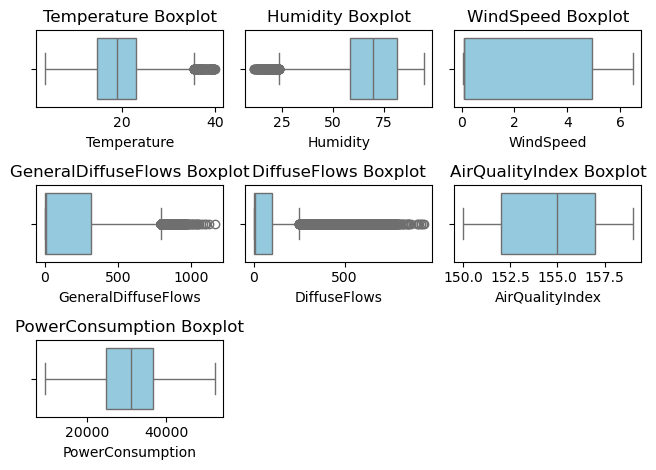

In [13]:
# Visualize outliers with boxplots
plt.Figure(figsize=(15,12))
numerical_cols = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
                  'DiffuseFlows', 'AirQualityIndex', 'PowerConsumption']

for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'{col} Boxplot')
plt.tight_layout()
plt.show()


In [14]:
# IQR-based outlier capping
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower, lower,
                          np.where(df[column] > upper, upper, df[column]))

# Apply to all relevant numeric columns
for col in numerical_cols:
    cap_outliers(df, col)

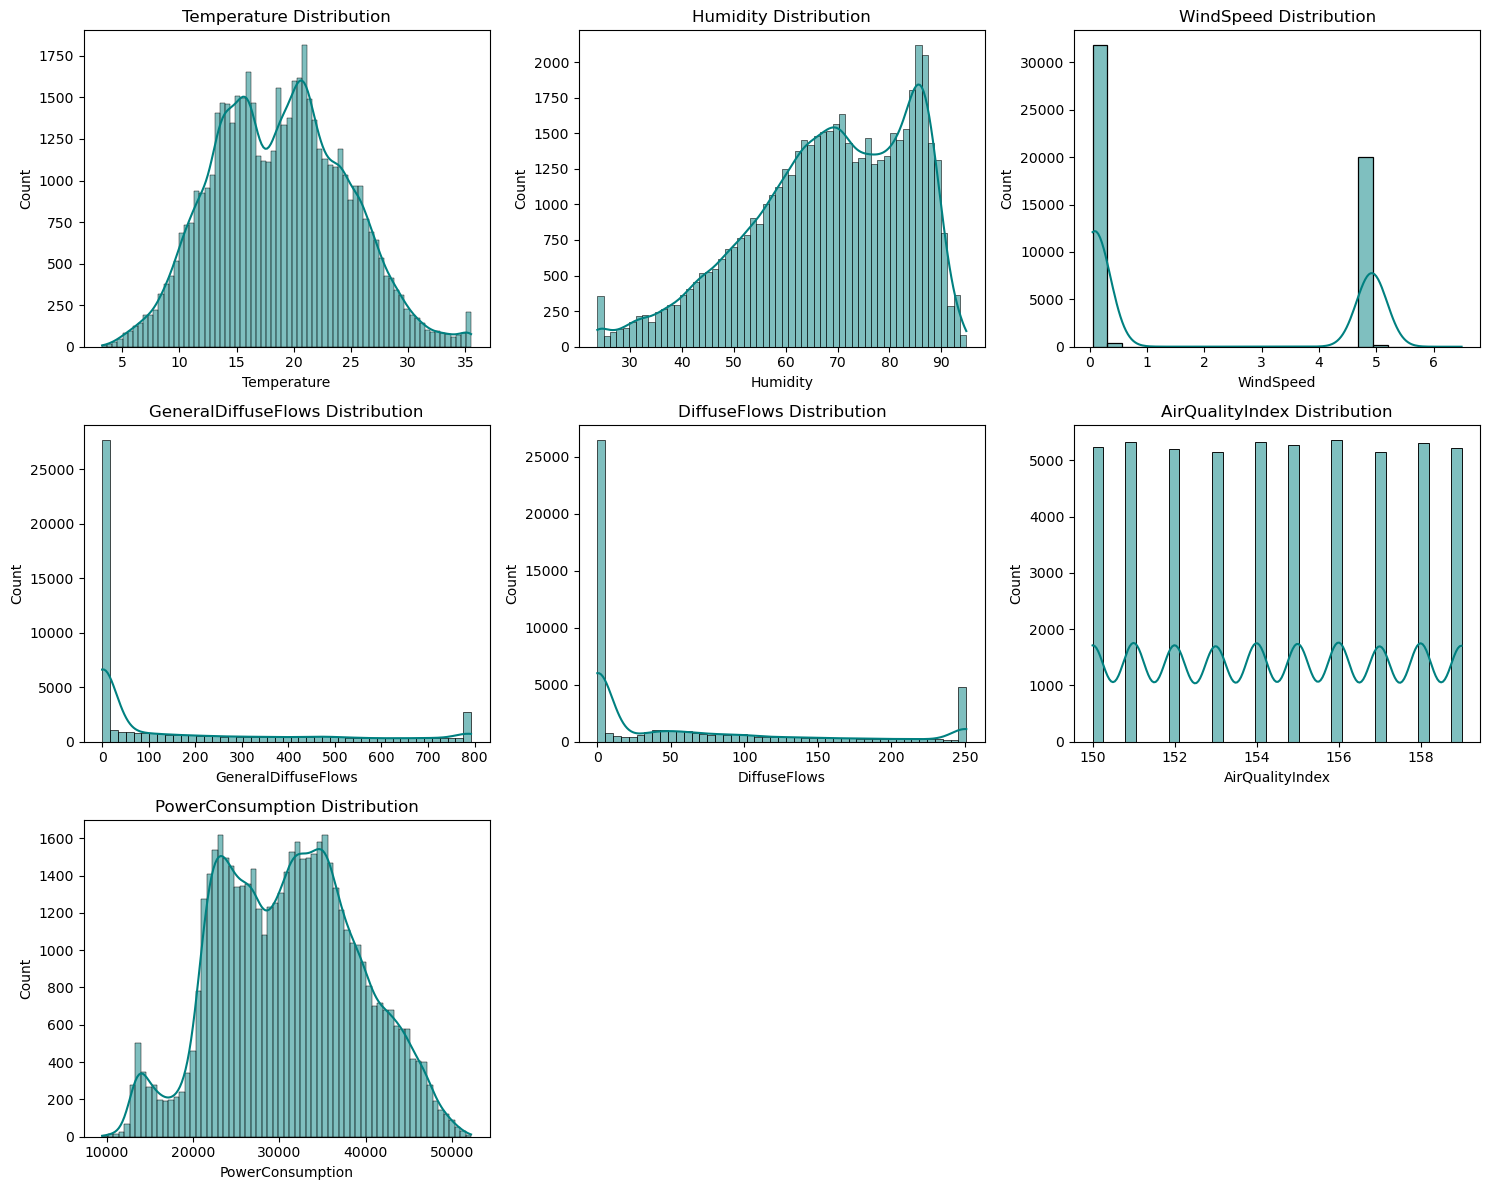

In [15]:
# Distribution plots
plt.figure(figsize=(15, 12))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col], kde=True, color='teal')
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

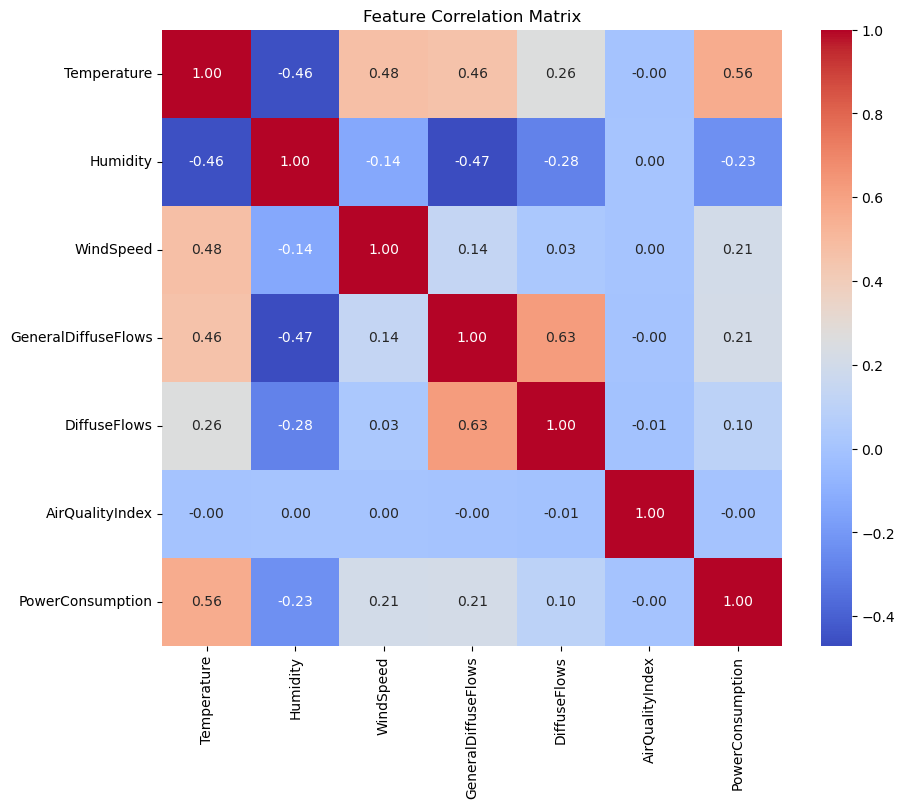

In [16]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

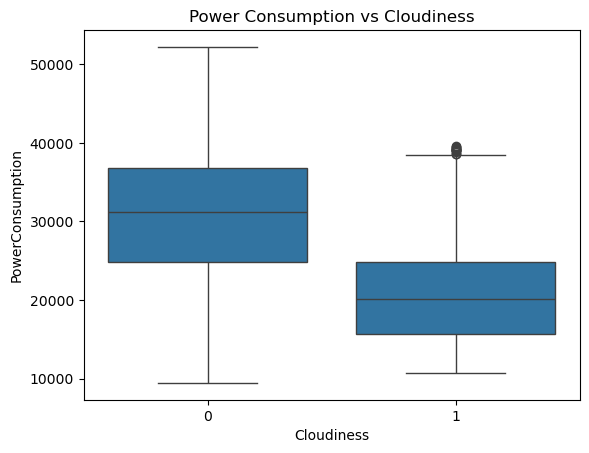

In [17]:
# Boxplot of Power Consumption by Cloudiness (0/1)
sns.boxplot(x='Cloudiness', y='PowerConsumption', data=df)
plt.title("Power Consumption vs Cloudiness")
plt.show()

In [18]:
# Adding interaction feature for linear models
df['Temp_Humidity'] = df['Temperature'] * df['Humidity']

In [19]:
# Feature scaling for linear models
X = df.drop(columns='PowerConsumption')  
y = df['PowerConsumption']



In [20]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# 10-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [22]:
# Linear Regression Pipeline
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

# Cross-validation
lr_scores = cross_val_score(lr_pipeline, X_train, y_train, cv=kfold, scoring='r2')
print("Linear Regression CV R² Scores:", lr_scores)
print("Mean R²:", lr_scores.mean())

Linear Regression CV R² Scores: [0.31442009 0.31457623 0.33823437 0.338865   0.32491285 0.3016927
 0.33992379 0.33666655 0.33411943 0.33056777]
Mean R²: 0.3273978779762322


In [23]:
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

print("Linear Regression Performance:")
print("R² Score:", r2_score(y_test, y_pred_lr))
print("RMSE:", root_mean_squared_error(y_test, y_pred_lr))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))


Linear Regression Performance:
R² Score: 0.3332478593480479
RMSE: 6562.924786831835
MAE: 5278.296369674077


In [24]:
# Model 2: Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf_scores = cross_val_score(rf, X_train, y_train, cv=kfold, scoring='r2')
print("Random Forest CV R² Scores:", rf_scores)
print("Mean R²:", rf_scores.mean())

# Final Evaluation
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Performance:")
print("R² Score:", r2_score(y_test, y_pred_rf))
print("RMSE:", root_mean_squared_error(y_test, y_pred_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))

Random Forest CV R² Scores: [0.646494   0.63329329 0.64877931 0.6364478  0.64517087 0.61559885
 0.6399444  0.65494406 0.65780766 0.63586636]
Mean R²: 0.6414346601850408
Random Forest Performance:
R² Score: 0.6577563423674129
RMSE: 4702.003219060018
MAE: 3259.9959310126355


In [25]:
# Model 3: XGBoost Regressor
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42,enable_categorical=True)
xgb_scores = cross_val_score(xgb, X_train, y_train, cv=kfold, scoring='r2')
print("XGBoost CV R² Scores:", xgb_scores)
print("Mean R²:", xgb_scores.mean())

# Final Evaluation
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Performance:")
print("R² Score:", r2_score(y_test, y_pred_xgb))
print("RMSE:", root_mean_squared_error(y_test, y_pred_xgb))
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))

XGBoost CV R² Scores: [0.51988654 0.51733647 0.53386682 0.52898631 0.53472379 0.50233152
 0.54014991 0.54709932 0.54901706 0.52376209]
Mean R²: 0.529715981658855
XGBoost Performance:
R² Score: 0.5364848042076107
RMSE: 5472.014078284707
MAE: 4137.87215496063


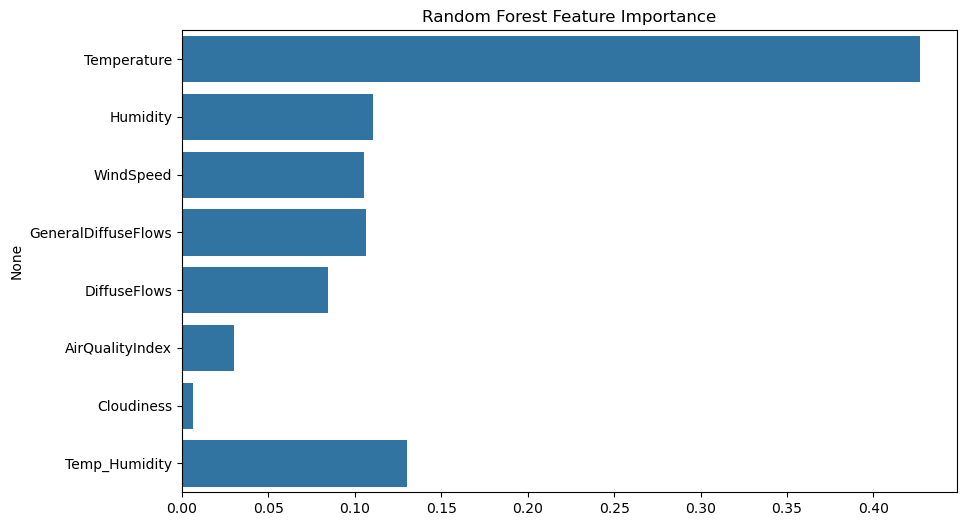

In [26]:
# Random Forest Feature Importance
importances = rf.feature_importances_
features = X.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features)
plt.title("Random Forest Feature Importance")
plt.show()

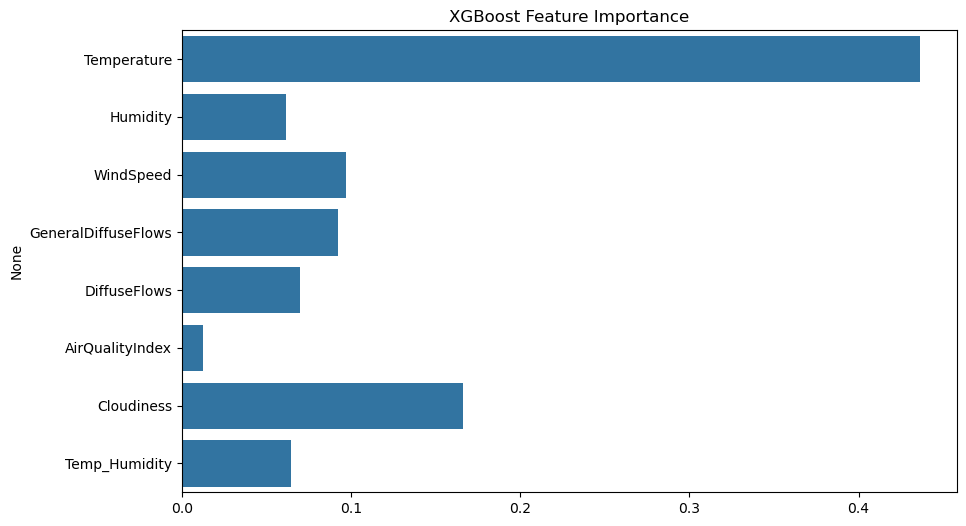

In [27]:
# XGB Feature Importance
xgb_importance = xgb.feature_importances_
plt.figure(figsize=(10,6))
sns.barplot(x=xgb_importance, y=features)
plt.title("XGBoost Feature Importance")
plt.show()

## Hyperparameter Tuning using RandomizedSearchCV

In [28]:
# Define Random Forest model and parameter grid
rf = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
# Set Up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,  
    cv=10,
    scoring='r2',
    verbose=2,
    n_jobs=1,
    random_state=42
)
# Fit the model
random_search.fit(X_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   3.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   3.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   3.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   3.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   3.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   3.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   3.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_esti

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
                   n_iter=30, n_jobs=1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, scoring='r2', verbose=2)

In [31]:
# Best Parameters & Final Model Evaluation
# Best parameters
print("Best Parameters from RandomizedSearchCV:")
print(random_search.best_params_)

# Best estimator
best_rf = random_search.best_estimator_

# Predict on test set
y_pred_tuned_rf = best_rf.predict(X_test)

# Evaluation
print("Tuned Random Forest Performance:")
print("R² Score:", r2_score(y_test, y_pred_tuned_rf))
print("RMSE:", root_mean_squared_error(y_test, y_pred_tuned_rf))
print("MAE:", mean_absolute_error(y_test, y_pred_tuned_rf))

Best Parameters from RandomizedSearchCV:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 40}
Tuned Random Forest Performance:
R² Score: 0.6533432063075014
RMSE: 4732.22162356527
MAE: 3345.6404674987198


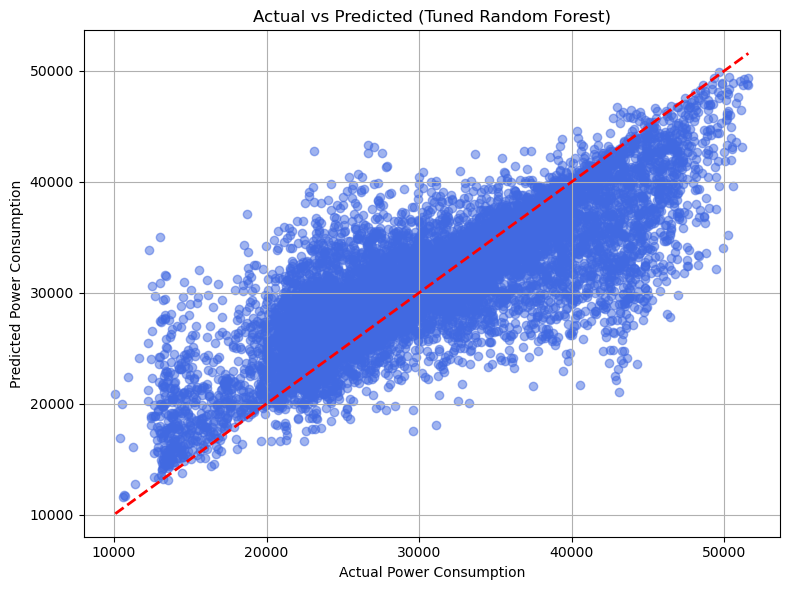

In [32]:
# Plotting Actual vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_tuned_rf, alpha=0.5, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
plt.xlabel('Actual Power Consumption')
plt.ylabel('Predicted Power Consumption')
plt.title('Actual vs Predicted (Tuned Random Forest)')
plt.grid(True)
plt.tight_layout()
plt.show()

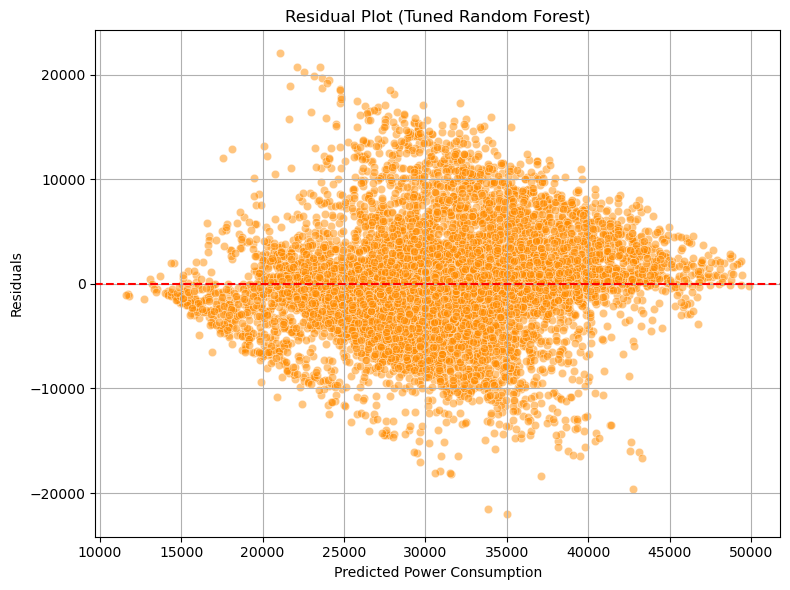

In [33]:
# Residual plot
residuals = y_test - y_pred_tuned_rf

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_tuned_rf, y=residuals, alpha=0.5, color='darkorange')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Power Consumption")
plt.ylabel("Residuals")
plt.title("Residual Plot (Tuned Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()

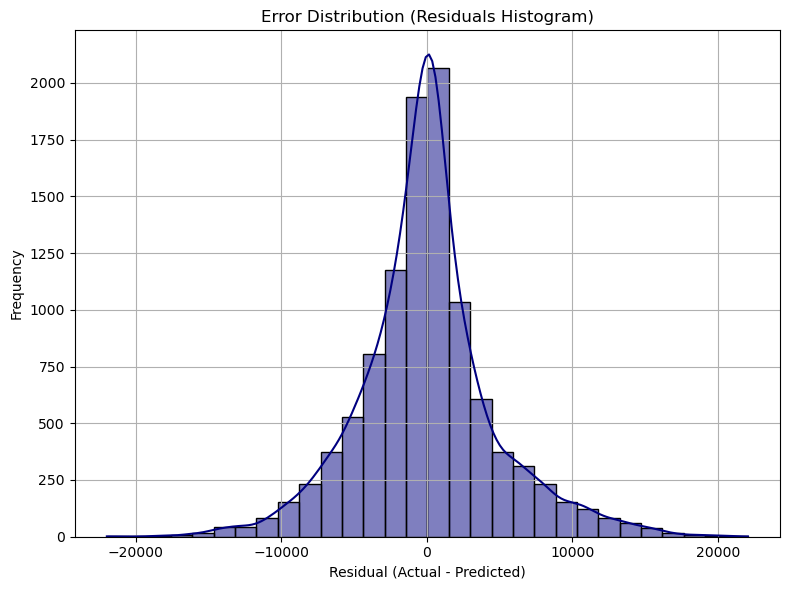

In [34]:
# Error Distribution
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='navy', bins=30)
plt.title("Error Distribution (Residuals Histogram)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()